## Review
### This recitation (11.29) covers following lecture below:
- **11.22 (Wed) :** 09_seq2seq_ind_0.ipynb
- **11.27 (Mon) :** 09_seq2seq_ind_1.ipynb

### Seq2Seq

*   Seq2Seq model is an RNN-based model designed for tasks that receive and output sequences, such as translation and summary.
*   The Seq2Seq model has 2 parts: "the part that accepts sequences" and "the part that outputs sequences."
*   The part that accepts the sequences (left orange RNN module) is called an encoder, and the part that outputs the sequences (right green RNN module) is called a decoder.
*   The encoder accepts the input sequence (original text) and converts it into a fixed-sized vector called a context vector.
*   The decoder receives the context vector generated by the encoder and outputs an output sequence (translation).



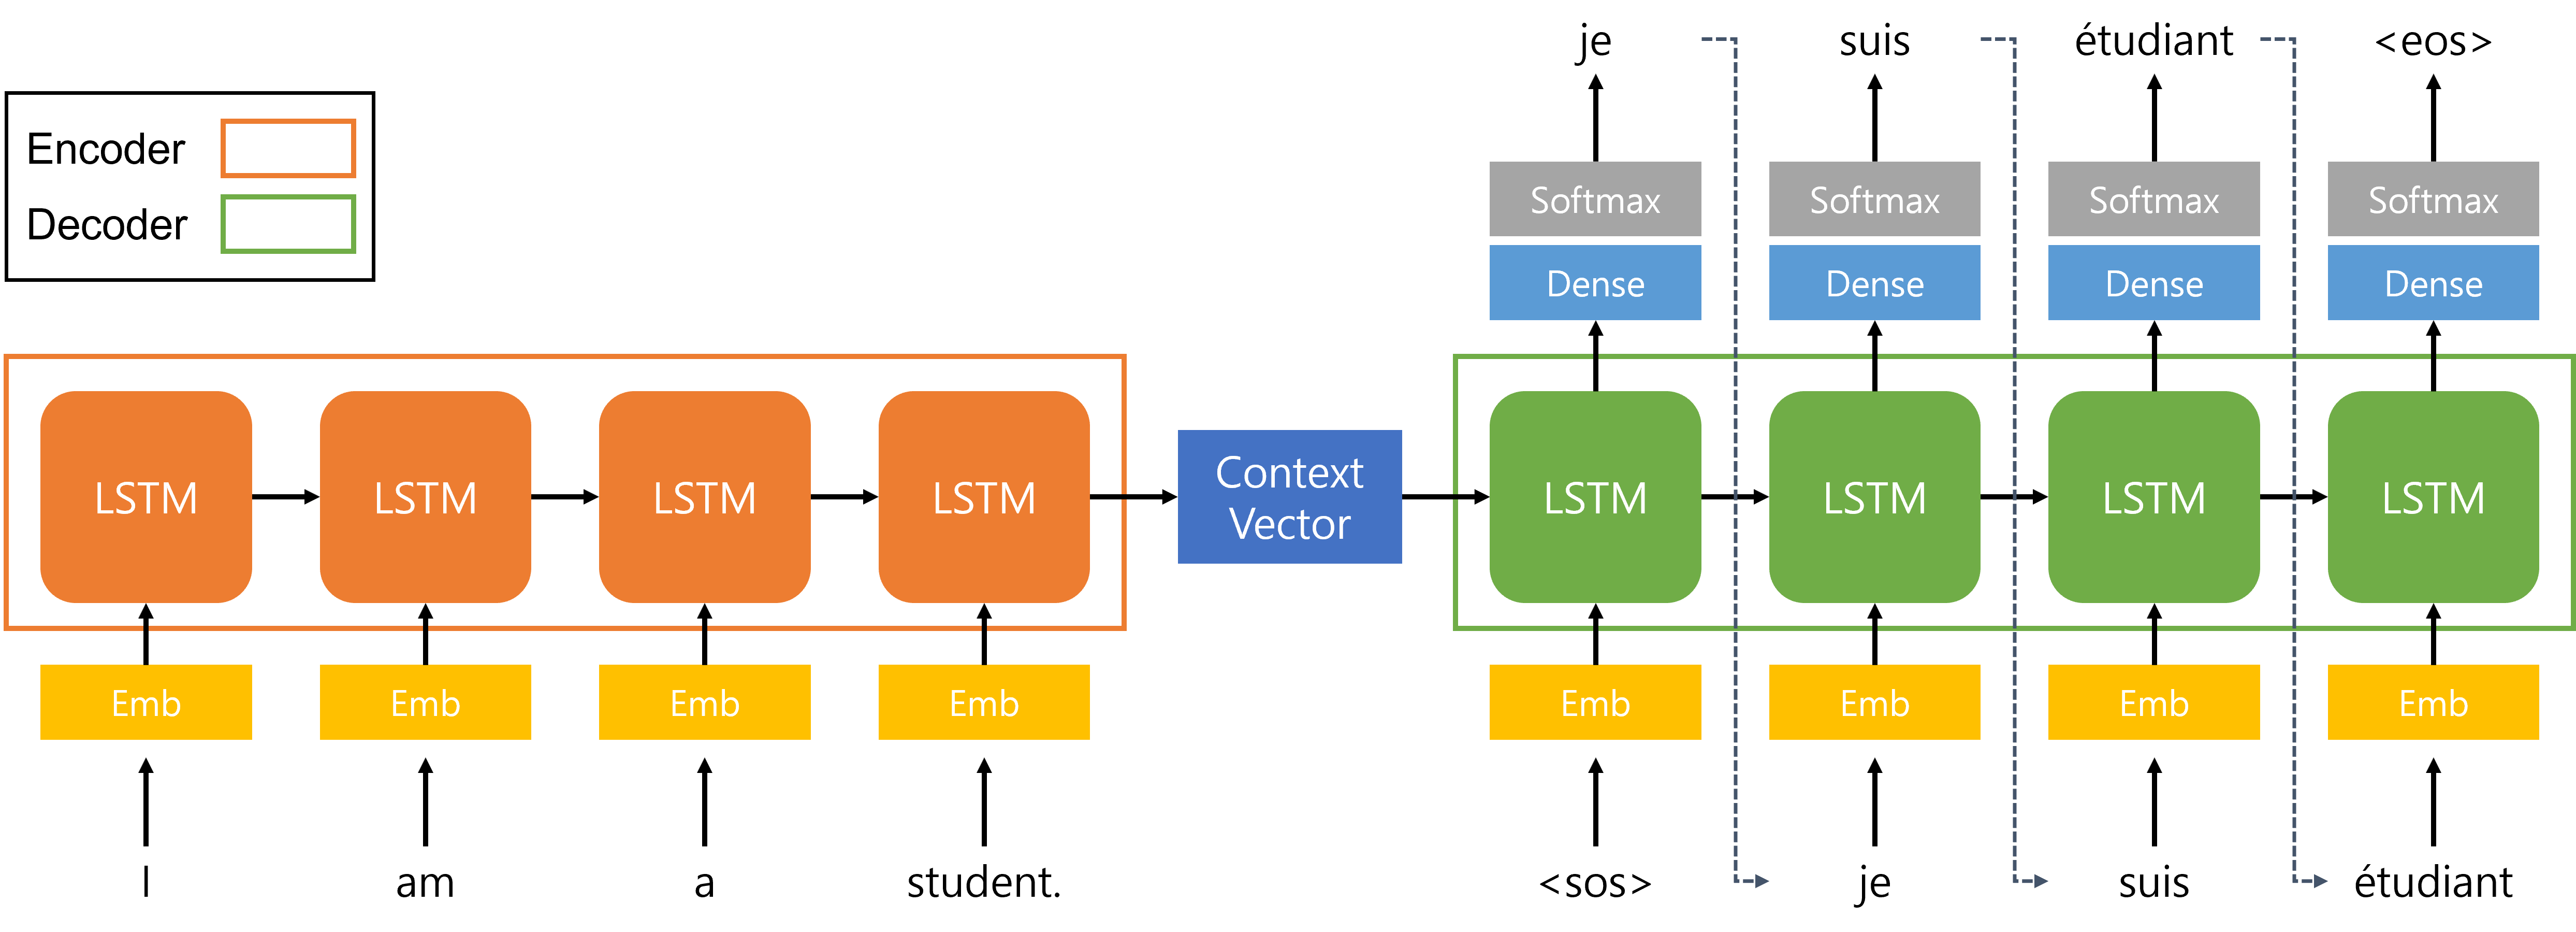





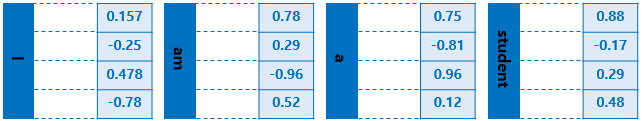

### Attention Mechanism



*   The basic idea of attention is that at every time step, the decoder predicts the output word, and the encoder references the entire input sentence.
*   Attention does not refer to all of the input sentences in the same proportion, but it will focus more on the input word part that is related to the word to be predicted at that point.



#### Attention Function

*   Attention(Q, K, V) = Attention Value

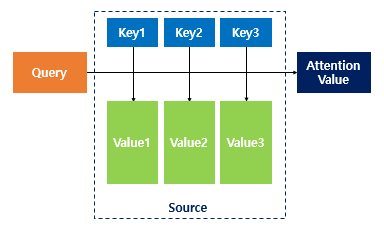

*   The attention function obtains the similarity of all 'Key' for a given 'Query'.
*   Reflect this similarity in each 'Value' mapped to the key.
*   Return by adding all the 'Value' reflecting similarity.

*   Q = Query: Concealment in the decoder cell at time t
*   K = Keys : Concealment states of encoder cells at all time points
*   V = Values : Concealment states of encoder cells at all time points

#### Dot-Product Attention

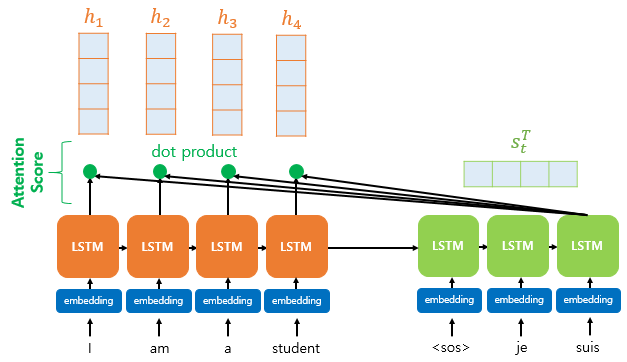

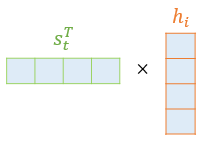

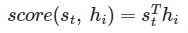

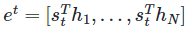

*   e: Attention score

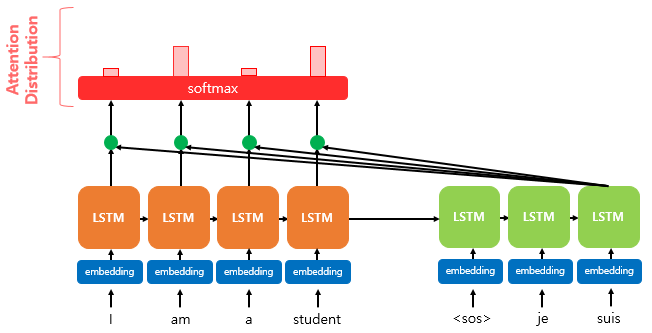

*   Attention Distribution: By applying the softmax function to e, we obtain a probability distribution that adds all the values to 1.

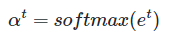

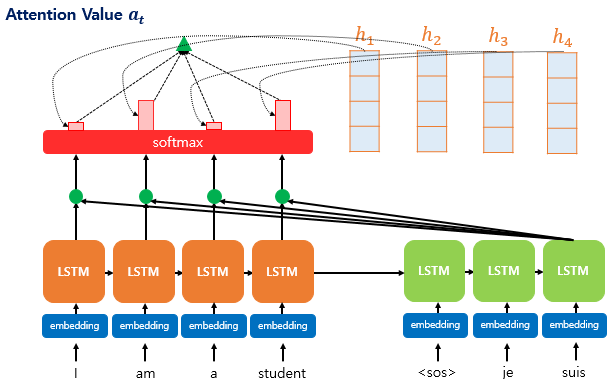

*   To obtain the final result of attention, multiply each encoder's hidden state and attention weights, and finally add all of them.

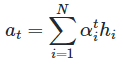

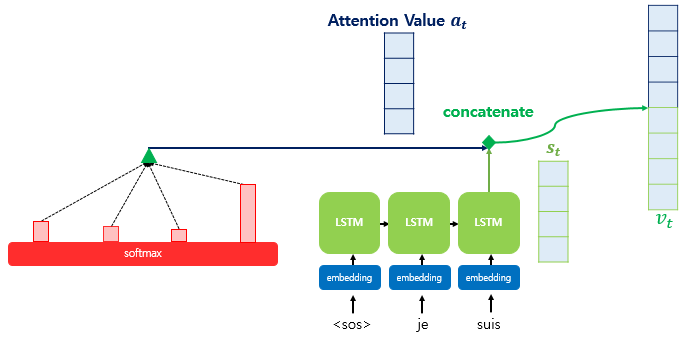

*   Connect the attention value with the hidden state at the time t of the decoder.

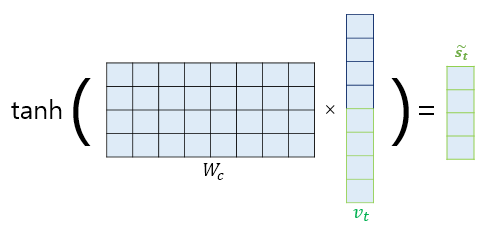

*   Calculates the s that is the input of the output layer operation.

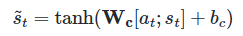

*   W_c: Trainable weights matrix
*   b_c: Bias

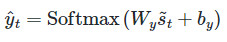

#### Implementation

In [ ]:
import numpy as np
from numpy.random import rand

def tanh(x):
	return np.tanh(x)

def sigmoid(x):
	return 1/(1 + np.exp(-x))

def sigmoid_grad(x):
	return x * (1.0 - x)

def tanh_grad(x):
	return 1 - x ** 2

def initalize(dim, init_range):
	return rand(*dim) * init_range

def zeros(*dim):
	return np.zeros(dim)

def ones(*dim):
	return np.ones(dim)

In [ ]:
class Softmax(object):
	def __init__(self, input_size, output_size, init_range = 1.0):
		self.input_size = input_size
		self.output_size = output_size

		self.W = initalize((output_size, input_size), init_range)
		self.dW = np.zeros((output_size, input_size))

		self.params = [
			('W', self.W, self.dW)
		]

	def initSequence(self):
		self.pred = []
		self.x = []
		self.targets = []
		self.t = 0
		self.dW[:] = 0

	def forward(self, x):
		self.t += 1

		y = self.W.dot(x)
		y = np.exp(y - y.max())
		y /= y.sum()

		self.pred.append(y)
		self.x.append(x)

		return y

	def backward(self, target):
		self.t -= 1
		self.targets.append(target)

		x = self.x[self.t]
		d = self.pred[self.t].copy()
		d[target] -= 1

		self.dW += np.outer(d, x)
		delta = np.dot(self.W.T, d)

		return delta

	def getCost(self):
		return sum(-np.log(y[target]) for target, y in zip(self.targets, reversed(self.pred)))

Review LSTM

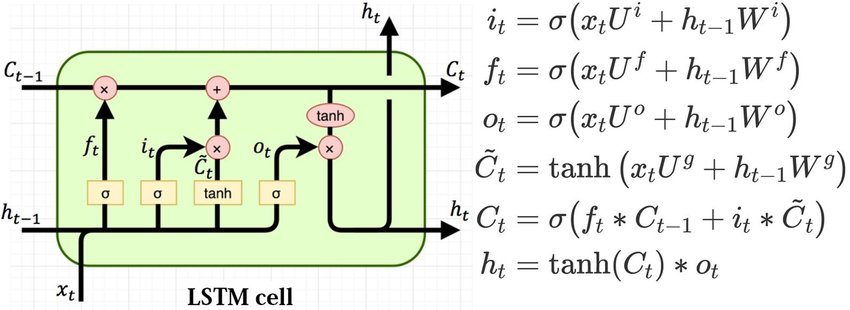

In [ ]:
class LSTM(object):
	def __init__(self, input_size, hidden_size, init_range = 1.0, previous = None):
		self.input_size = input_size
		self.hidden_size = hidden_size

		if previous:
			self.previous = previous
			previous.next = self

		def init(x, y):
			return initalize((x, y), init_range)

		h, n = hidden_size, input_size
		# initialize weights
		self.W_hi, self.W_hf, self.W_ho, self.W_hj = init(h, h), init(h, h), init(h, h), init(h, h)
		self.W_xi, self.W_xf, self.W_xo, self.W_xj = init(h, n), init(h, n), init(h, n), init(h, n)
		self.b_i, self.b_f, self.b_o, self.b_j = zeros(h), ones(h) * 3, zeros(h), zeros(h)

		# initalize gradients
		self.dW_hi, self.dW_hf, self.dW_ho, self.dW_hj = zeros(h, h), zeros(h, h), zeros(h, h), zeros(h, h)
		self.dW_xi, self.dW_xf, self.dW_xo, self.dW_xj = zeros(h, n), zeros(h, n), zeros(h, n), zeros(h, n)
		self.db_i, self.db_f, self.db_o, self.db_j = zeros(h), zeros(h), zeros(h), zeros(h)

		# list of all parameters
		self.params = [
			('W_hi', self.W_hi, self.dW_hi),
			('W_hf', self.W_hf, self.dW_hf),
			('W_ho', self.W_ho, self.dW_ho),
      ('W_hj', self.W_hj, self.dW_hj),

      ('W_xi', self.W_xi, self.dW_xi),
      ('W_xf', self.W_xf, self.dW_xf),
      ('W_xo', self.W_xo, self.dW_xo),
      ('W_xj', self.W_xj, self.dW_xj),

      ('b_i', self.b_i, self.db_i),
      ('b_f', self.b_f, self.db_f),
      ('b_o', self.b_o, self.db_o),
      ('b_j', self.b_j, self.db_j),
		]

		self.initSequence()

	def initSequence(self):
		self.t = 0
		self.x = {}
		self.h = {}
		self.c = {}
		self.ct = {}

		self.input_gate = {}
		self.forget_gate = {}
		self.output_gate = {}
		self.cell_update = {}

		if hasattr(self, 'previous'):
			self.h[0] = self.previous.h[self.previous.t]
			self.c[0] = self.previous.c[self.previous.t]
		else:
			self.h[0] = zeros(self.hidden_size)
			self.c[0] = zeros(self.hidden_size)

		if hasattr(self, 'next'):
			self.dh_prev = self.next.dh_prev
			self.dc_prev = self.next.dc_prev
		else:
			self.dh_prev = zeros(self.hidden_size)
			self.dc_prev = zeros(self.hidden_size)

		for name, params, grad in self.params:
			grad[:] = 0

	def forward(self, x_t):
		self.t += 1
		t = self.t
		h = self.h[t-1]

		# YOUR CODE HERE

		self.c[t] = self.input_gate[t] * self.cell_update[t] + self.forget_gate[t] * self.c[t-1]
		self.ct[t] = tanh(self.c[t])
		self.h[t] = self.output_gate[t] * self.ct[t]

		self.x[t] = x_t

		return self.h[t]

	def backward(self, dh):
		t = self.t

		dh = dh + self.dh_prev
		dc = tanh_grad(self.ct[t]) * self.output_gate[t] * dh + self.dc_prev

		# YOUR CODE HERE

		self.dc_prev = self.forget_gate[t] * dc

		self.db_i += d_input
		self.db_f += d_forget
		self.db_o += d_output
		self.db_j += d_update

		h_in = self.h[t-1]

		self.dW_xi += np.outer(d_input, self.x[t])
		self.dW_xf += np.outer(d_forget, self.x[t])
		self.dW_xo += np.outer(d_output, self.x[t])
		self.dW_xj += np.outer(d_update, self.x[t])

		self.dW_hi += np.outer(d_input, h_in)
		self.dW_hf += np.outer(d_forget, h_in)
		self.dW_ho += np.outer(d_output, h_in)
		self.dW_hj += np.outer(d_update, h_in)

		self.dh_prev = np.dot(self.W_hi.T, d_input)
		self.dh_prev += np.dot(self.W_hf.T, d_forget)
		self.dh_prev += np.dot(self.W_ho.T, d_output)
		self.dh_prev += np.dot(self.W_hj.T, d_update)

		dX = np.dot(self.W_xi.T, d_input)
		dX += np.dot(self.W_xf.T, d_forget)
		dX += np.dot(self.W_xo.T, d_output)
		dX += np.dot(self.W_xj.T, d_update)

		self.t -= 1

		return dX

In [ ]:
class Embedding(object):
	def __init__(self, vocab_size, embed_size, init_range = 1.0):
		self.vocab_size = vocab_size
		self.embed_size = embed_size
		self.W = initalize((vocab_size, embed_size), init_range)
		self.dW = np.zeros(self.W.shape)

		self.params = [
			('W', self.W, self.dW)
		]

	def initSequence(self):
		self.t = 0
		self.x = {}
		self.dW[:] = 0

	def forward(self, x):
		self.x[self.t] = x
		self.t += 1

		return self.W[x]

	def backward(self, delta):
		self.t -= 1
		x = self.x[self.t]

		self.dW[x] += delta

In [ ]:
EOS = 0

HIDDEN_SIZE = 20
EMBED_SIZE = 20
INPUT_SIZE = 4
OUTPUT_SIZE = 4
INIT_RANGE = 1.0

LEARNING_RATE = 0.01
CLIP_GRAD = 5.0

class Seq2seq(object):

	def __init__(self, input_size = INPUT_SIZE, output_size = OUTPUT_SIZE, hidden_size = HIDDEN_SIZE, embed_size = EMBED_SIZE, lr = LEARNING_RATE, clip_grad = CLIP_GRAD, init_range = INIT_RANGE):
		input_layers = [
			Embedding(input_size, embed_size, init_range),
			LSTM(embed_size, hidden_size, init_range)
		]

		output_layers = [
			Embedding(output_size, embed_size, init_range),
			LSTM(embed_size, hidden_size, init_range, previous = input_layers[1]),
			Softmax(hidden_size, output_size, init_range)
		]

		self.input_layers, self.output_layers = input_layers, output_layers
		self.hidden_size = hidden_size
		self.embed_size = embed_size
		self.input_size = input_size
		self.output_size = output_size
		self.lr = lr
		self.clip_grad = clip_grad

	def predict(self, X, max_length = 10):
		# Init to take a new sequence for the encoder
		for layer in self.input_layers:
			layer.initSequence()

		# FORWARD encoder
		# YOUR CODE HERE

		# Init to take a new sequence for the decoder
		for layer in self.output_layers:
			layer.initSequence()

		# Output model
		out = []
		token = EOS

		while len(out) < max_length:
			# Start with last generated token
			h = token

			# FORWARD decoder
			# YOUR CODE HERE

			# Select token with highest softmax activation
			token = np.argmax(h)

			# Stop if we generated EOS token
			# YOUR CODE HERE

			# Add token to output sequence
			out.append(token)

		return out

	def train(self, X, Y):
		# Init to take a new sequence for the encoder
		for layer in self.input_layers:
			layer.initSequence()

		# FORWARD encoder
		# YOUR CODE HERE

		# Init to take a new sequence for the decoder
		for layer in self.output_layers:
			layer.initSequence()

		# FORWARD decoder
		# YOUR CODE HERE

		# BACKWARD decoder
		# YOUR CODE HERE

		# BACKWARD encoder
		# YOUR CODE HERE

		grad_norm = 0.0

		# Gradient clipping
		for layer in self.input_layers + self.output_layers:
			for name, param, grad in layer.params:
				if grad_norm > self.clip_grad:
					grad /= grad_norm / self.clip_grad
				param -= self.lr * grad

		return self.output_layers[-1].getCost()

In [ ]:
# Example 1
seq2seq = Seq2seq(lr=0.3, init_range=0.3)

for i in range(1000):
  cost = seq2seq.train([2, 1], [2])
  cost += seq2seq.train([1], [1])
  cost += seq2seq.train([3, 1], [3])

  if i % 100 == 0:
    print('Epoch:', i)
    print('training cost:', cost / 3)

    print([2, 1], '->', seq2seq.predict([2, 1]))
    print([1], '->', seq2seq.predict([1]))
    print([3, 1], '->', seq2seq.predict([3, 1]))

In [ ]:
# Example 2
from random import randint

seq2seq = Seq2seq()

last_seq = None
cost = 0

for i in range(100000):
  X = [randint(1, 2) for _ in range(randint(1, 10))]
  Y = [x for x in X if x == 1]
  cost += seq2seq.train(X, Y)

  if i % 1000 == 0:
    print(i, '\t', cost / 1000)
    cost = 0

    X = [randint(1, 2) for _ in range(randint(1, 10))]
    Y = seq2seq.predict(X)

    print(X, '->', Y)

    seq2seq.lr /= 2

### BLEU Score(Bilingual Evaluation Understudy Score)


*   BLEU is a method of measuring performance for translation by comparing machine translation results with human translation results.



#### Unigram Precision

*   Measure by counting the number of words

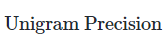
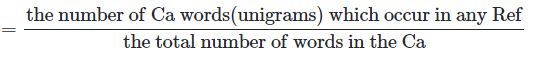

Example

*   Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.
*   Candidate2 : It is to insure the troops forever hearing the activity guidebook that party direct.
*   Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.
*   Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.
*   Reference3 : It is the practical guide for the army always to heed the directions of the party.

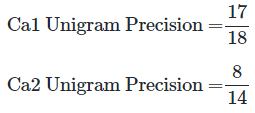

#### Modified Unigram Precision

Example


*   Candidate : the the the the the the the
*   Reference1 : the cat is on the mat
*   Reference2 : there is a cat on the mat

Unigram Precision = 1 --> We have to modify!

*   Calibrate by eliminating duplicates

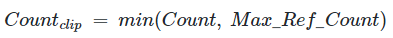

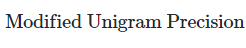
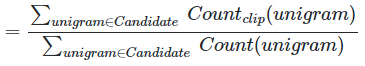

In [ ]:
import numpy as np
from collections import Counter
from nltk import ngrams

def simple_count(tokens, n):
  return Counter(ngrams(tokens, n))

In [ ]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."
tokens = candidate.split()
result = simple_count(tokens, 1)
print('Unigram count :',result)

Unigram count : Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


In [ ]:
candidate = 'the the the the the the the'
tokens = candidate.split()
result = simple_count(tokens, 1)
print('Unigram count :',result)

Unigram count : Counter({('the',): 7})


In [ ]:
# Modified Unigram
def count_clip(candidate, reference_list, n):
  ca_cnt = simple_count(candidate, n)
  max_ref_cnt_dict = dict()

  for ref in reference_list:
    ref_cnt = simple_count(ref, n)

    for n_gram in ref_cnt:
      if n_gram in max_ref_cnt_dict:
        max_ref_cnt_dict[n_gram] = max(ref_cnt[n_gram], max_ref_cnt_dict[n_gram])
      else:
        max_ref_cnt_dict[n_gram] = ref_cnt[n_gram]

  return {
        n_gram: min(ca_cnt.get(n_gram, 0), max_ref_cnt_dict.get(n_gram, 0)) for n_gram in ca_cnt
     }

In [ ]:
candidate = 'the the the the the the the'
references = [
    'the cat is on the mat',
    'there is a cat on the mat'
]
result = count_clip(candidate.split(),list(map(lambda ref: ref.split(), references)),1)
print('Modified Unigram count :',result)

In [ ]:
def modified_precision(candidate, reference_list, n):
  clip_cnt = count_clip(candidate, reference_list, n)
  total_clip_cnt = sum(clip_cnt.values())

  cnt = simple_count(candidate, n)
  total_cnt = sum(cnt.values())

  if total_cnt == 0:
    total_cnt = 1

  return (total_clip_cnt / total_cnt)

In [ ]:
result = modified_precision(candidate.split(), list(map(lambda ref: ref.split(), references)), n=1)
print('Modified Unigram Precision :',result)

#### n-gram


*   Expand to n-gram to consider order

Example


*   Candidate1 : the the the the the the the
*   Candidate2 : the cat the cat on the mat
*   Reference1 : the cat is on the mat
*   Reference2 : there is a cat on the mat



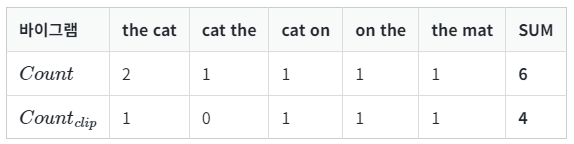

*   Ca1 Bigram Precision = 0
*   Ca2 Bigram Precision = 4/6

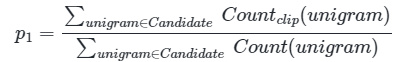

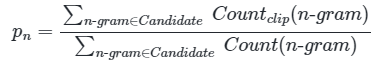

#### BLEU

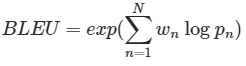

*   P_n: Modified precision for each gram
*   N: Maximum number of n in n-gram
*   w_n: We can give different weights to the modified precision of each gram. The sum of these weights is 1.

#### Brevity Penalty

*   If Ca has a shorter sentence length than Ref, the score needs to be penalized.

Example

*   Candidate 1: I always invariably perpetually do.
*   Candidate 2: I always do.
*   Reference 1: I always do.
*   Reference 2: I invariably do.
*   Reference 3: I perpetually do.

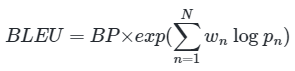

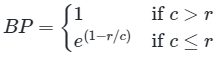

In [ ]:
# A function that returns the length of the Ref closest to the length of Ca
def closest_ref_length(candidate, reference_list):
  ca_len = len(candidate)
  ref_lens = (len(ref) for ref in reference_list)
  closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
  return closest_ref_len

In [ ]:
def brevity_penalty(candidate, reference_list):
  ca_len = len(candidate)
  ref_len = closest_ref_length(candidate, reference_list)

  # YOUR CODE HERE


In [ ]:
def bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
  bp = brevity_penalty(candidate, reference_list)

  p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights,start=1)]
  # p1, p2, p3, ..., pn
  score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
  return bp * np.exp(score)

In [ ]:
candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('BLEU :',bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))